In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import Holt

In [2]:
class Confidence():
    def __init__(self, z, holt_z):
        self.z = z  # 2.58
        self.holt_z = holt_z # 3.219

    def confidenceInterval(self, use_INT_arr):
        return np.mean(use_INT_arr) + ( self.z * (np.std(use_INT_arr) / np.sqrt(len(use_INT_arr))) )

    def holtLower(self, fcast, se):
        return fcast - ( self.holt_z * se )

    def holtCheck(self, fcast, se):
        MIN = fcast - ( self.holt_z * se )
        MAX = fcast + ( self.holt_z * se )
        return MIN, MAX

In [3]:
class HoltTech():
    def __init__(self, level, trend):
        self.level = level
        self.trend = trend

        self.preL = 0
        self.preB = 0

    def holtForcast(self, x):
        
        if self.preL == 0:
            self.preL = x
            self.preB = 0
            return x
        
        l = (self.level * x) + (1 - self.level) * (self.preL + self.preB)
        b = self.trend * (l - self.preL) + (1 - self.trend) * self.preB

        res = l + b

        self.preL = l
        self.preB = b

        return res

In [4]:
class KalmanFilter():
    
    # processNoise = 0.0 # Process noise
    # measurementNoise = 0.0 # Measurement noise
    # estimatedRSSI = 0.0 # calculated rssi
    # errorCovarianceRSSI = 0.0 # calculated covariance
    # isInitialized = False # initialization flag

    def __init__(self, processNoise, measurementNoise):
        super(KalmanFilter, self).__init__()
        self.processNoise = processNoise # Process noise = 0.0005
        self.measurementNoise = measurementNoise # Measurement noise = 20
        self.estimatedRSSI = 0.0 # calculated rssi
        self.errorCovarianceRSSI = 0.0 # calculated covariance
        self.isInitialized = False # initialization flag

    def applyFilter(self, rssi):
        priorRSSI = 0.0
        kalmanGain = 0.0
        priorErrorCovarianceRSSI = 0.0

        if not self.isInitialized:
            priorRSSI = rssi
            priorErrorCovarianceRSSI = 1
            self.isInitialized = True
        else:
            priorRSSI = self.estimatedRSSI
            priorErrorCovarianceRSSI = self.errorCovarianceRSSI + self.processNoise

        kalmanGain = priorErrorCovarianceRSSI / (priorErrorCovarianceRSSI + self.measurementNoise)
        self.estimatedRSSI = priorRSSI + (kalmanGain * (rssi - priorRSSI))
        self.errorCovarianceRSSI = (1 - kalmanGain) * priorErrorCovarianceRSSI

        return self.estimatedRSSI

In [5]:
class RSSI():
    def __init__(self):
        self.fcast = 0
        self.power_sum = 0
        self.se = 0
        self.idx = 2
        
        self.confi = Confidence(z=2.58, holt_z=3.219)
        self.holt = HoltTech(level = 0.9, trend = 0.4)
        self.KF = KalmanFilter(processNoise = 0.4, measurementNoise = 5)
        
        self.lower = 0
        self.upper = 0

    def check_rssi(self, rssi, test):
        pre_data = self.KF.applyFilter(rssi)
        
        if self.lower != 0 and self.upper != 0:
            if test:
                if pre_data < self.lower or pre_data > self.upper :
                    return True
                else:
                    return False
    
        if self.fcast == 0:     
            self.fcast = self.holt.holtForcast(pre_data)
            return
    
        self.power_sum += np.power(pre_data - self.fcast, 2)

        if self.se == 0:
            self.se = np.sqrt(self.power_sum / ( self.idx - 1 ))
            self.fcast = self.holt.holtForcast(pre_data)
            self.idx += 1
            return
    
        self.fcast = self.holt.holtForcast(pre_data)
        self.lower, self.upper = self.confi.holtCheck(self.fcast, self.se)
        self.se = np.sqrt(self.power_sum / ( self.idx - 1))
        self.idx += 1
        
        return False

In [6]:
res = []
    
for j in range(1, 2701):
    print("Start: " + str(j))
    df = pd.read_csv('./test_data0/data' + str(j) + '.csv')

    df_time = df['time']
    df_rssi = df['rssi']
    case = 5
    mini_range = 0.3
    
    int_flag = False
    rssi_flag = False

    if len(df_time) > 95:
        case = 10
    elif len(df_time) > 495:
        case = 50
        
    if j >= 901 and j <= 1800:
        mini_range = 0.17
    elif j >= 1801 and j <= 2700:
        mini_range = 0.05

    RSSI_d = RSSI()

    for i in range(len(df_rssi)):
        if i < len(df_rssi) - 1:
            RSSI_d.check_rssi(df_rssi[i], False)
        else:
            if not rssi_flag:
                rssi_res = RSSI_d.check_rssi(df_rssi[i], True)

                if rssi_res:
                    rssi_flag = True
                    break

    if rssi_flag:
        res.append(True)
    else:
        res.append(False)

Start: 1
Start: 2
Start: 3
Start: 4
Start: 5
Start: 6
Start: 7
Start: 8
Start: 9
Start: 10
Start: 11
Start: 12
Start: 13
Start: 14
Start: 15
Start: 16
Start: 17
Start: 18
Start: 19
Start: 20
Start: 21
Start: 22
Start: 23
Start: 24
Start: 25
Start: 26
Start: 27
Start: 28
Start: 29
Start: 30
Start: 31
Start: 32
Start: 33
Start: 34
Start: 35
Start: 36
Start: 37
Start: 38
Start: 39
Start: 40
Start: 41
Start: 42
Start: 43
Start: 44
Start: 45
Start: 46
Start: 47
Start: 48
Start: 49
Start: 50
Start: 51
Start: 52
Start: 53
Start: 54
Start: 55
Start: 56
Start: 57
Start: 58
Start: 59
Start: 60
Start: 61
Start: 62
Start: 63
Start: 64
Start: 65
Start: 66
Start: 67
Start: 68
Start: 69
Start: 70
Start: 71
Start: 72
Start: 73
Start: 74
Start: 75
Start: 76
Start: 77
Start: 78
Start: 79
Start: 80
Start: 81
Start: 82
Start: 83
Start: 84
Start: 85
Start: 86
Start: 87
Start: 88
Start: 89
Start: 90
Start: 91
Start: 92
Start: 93
Start: 94
Start: 95
Start: 96
Start: 97
Start: 98
Start: 99
Start: 100
Start: 1

Start: 773
Start: 774
Start: 775
Start: 776
Start: 777
Start: 778
Start: 779
Start: 780
Start: 781
Start: 782
Start: 783
Start: 784
Start: 785
Start: 786
Start: 787
Start: 788
Start: 789
Start: 790
Start: 791
Start: 792
Start: 793
Start: 794
Start: 795
Start: 796
Start: 797
Start: 798
Start: 799
Start: 800
Start: 801
Start: 802
Start: 803
Start: 804
Start: 805
Start: 806
Start: 807
Start: 808
Start: 809
Start: 810
Start: 811
Start: 812
Start: 813
Start: 814
Start: 815
Start: 816
Start: 817
Start: 818
Start: 819
Start: 820
Start: 821
Start: 822
Start: 823
Start: 824
Start: 825
Start: 826
Start: 827
Start: 828
Start: 829
Start: 830
Start: 831
Start: 832
Start: 833
Start: 834
Start: 835
Start: 836
Start: 837
Start: 838
Start: 839
Start: 840
Start: 841
Start: 842
Start: 843
Start: 844
Start: 845
Start: 846
Start: 847
Start: 848
Start: 849
Start: 850
Start: 851
Start: 852
Start: 853
Start: 854
Start: 855
Start: 856
Start: 857
Start: 858
Start: 859
Start: 860
Start: 861
Start: 862
Start: 863

Start: 1487
Start: 1488
Start: 1489
Start: 1490
Start: 1491
Start: 1492
Start: 1493
Start: 1494
Start: 1495
Start: 1496
Start: 1497
Start: 1498
Start: 1499
Start: 1500
Start: 1501
Start: 1502
Start: 1503
Start: 1504
Start: 1505
Start: 1506
Start: 1507
Start: 1508
Start: 1509
Start: 1510
Start: 1511
Start: 1512
Start: 1513
Start: 1514
Start: 1515
Start: 1516
Start: 1517
Start: 1518
Start: 1519
Start: 1520
Start: 1521
Start: 1522
Start: 1523
Start: 1524
Start: 1525
Start: 1526
Start: 1527
Start: 1528
Start: 1529
Start: 1530
Start: 1531
Start: 1532
Start: 1533
Start: 1534
Start: 1535
Start: 1536
Start: 1537
Start: 1538
Start: 1539
Start: 1540
Start: 1541
Start: 1542
Start: 1543
Start: 1544
Start: 1545
Start: 1546
Start: 1547
Start: 1548
Start: 1549
Start: 1550
Start: 1551
Start: 1552
Start: 1553
Start: 1554
Start: 1555
Start: 1556
Start: 1557
Start: 1558
Start: 1559
Start: 1560
Start: 1561
Start: 1562
Start: 1563
Start: 1564
Start: 1565
Start: 1566
Start: 1567
Start: 1568
Start: 1569
Star

Start: 2181
Start: 2182
Start: 2183
Start: 2184
Start: 2185
Start: 2186
Start: 2187
Start: 2188
Start: 2189
Start: 2190
Start: 2191
Start: 2192
Start: 2193
Start: 2194
Start: 2195
Start: 2196
Start: 2197
Start: 2198
Start: 2199
Start: 2200
Start: 2201
Start: 2202
Start: 2203
Start: 2204
Start: 2205
Start: 2206
Start: 2207
Start: 2208
Start: 2209
Start: 2210
Start: 2211
Start: 2212
Start: 2213
Start: 2214
Start: 2215
Start: 2216
Start: 2217
Start: 2218
Start: 2219
Start: 2220
Start: 2221
Start: 2222
Start: 2223
Start: 2224
Start: 2225
Start: 2226
Start: 2227
Start: 2228
Start: 2229
Start: 2230
Start: 2231
Start: 2232
Start: 2233
Start: 2234
Start: 2235
Start: 2236
Start: 2237
Start: 2238
Start: 2239
Start: 2240
Start: 2241
Start: 2242
Start: 2243
Start: 2244
Start: 2245
Start: 2246
Start: 2247
Start: 2248
Start: 2249
Start: 2250
Start: 2251
Start: 2252
Start: 2253
Start: 2254
Start: 2255
Start: 2256
Start: 2257
Start: 2258
Start: 2259
Start: 2260
Start: 2261
Start: 2262
Start: 2263
Star

In [7]:
len(res)

2700

In [8]:
print((res.count(True) / len(res)) * 100)

65.88888888888889


In [9]:
case_50 = res[0:300] + res[900:1200] + res[1800:2100]
case_100 = res[300:600] + res[1200:1500] + res[2100:2400]
case_500 = res[600:900] + res[1500:1800] + res[2400:2700]

case_0 = res[0:100] + res[300:400] + res[600:700] + res[900:1000] + res[1200:1300] + res[1500:1600] + res[1800:1900] + res[2100:2200] + res[2400:2500]
case_1 = res[100:200] + res[400:500] + res[700:800] + res[1000:1100] + res[1300:1400] + res[1600:1700] + res[1900:2000] + res[2200:2300] + res[2500:2600]
case_2 = res[200:300] + res[500:600] + res[800:900] + res[1100:1200] + res[1400:1500] + res[1700:1800] + res[2000:2100] + res[2300:2400] + res[2600:2700]

case_fast = res[1800:2700]
case_normal = res[900:1800]
case_slow = res[0:900]

In [10]:
acc_50 = case_50.count(True)
acc_100 = case_100.count(True)
acc_500 = case_500.count(True)

acc_0 = case_0.count(True)
acc_1 = case_1.count(True)
acc_2 = case_2.count(True)

acc_fast = case_fast.count(True)
acc_normal = case_normal.count(True)
acc_slow = case_slow.count(True)

In [11]:
print(acc_50 / len(case_50) * 100)
print(acc_100 / len(case_100) * 100)
print(acc_500 / len(case_500) * 100)

print(acc_0 / len(case_0) * 100)
print(acc_1 / len(case_1) * 100)
print(acc_2 / len(case_2) * 100)

print(acc_fast / len(case_fast) * 100)
print(acc_normal / len(case_normal) * 100)
print(acc_slow / len(case_slow) * 100)

65.11111111111111
66.33333333333333
66.22222222222223
0.5555555555555556
97.22222222222221
99.8888888888889
66.55555555555556
65.11111111111111
66.0


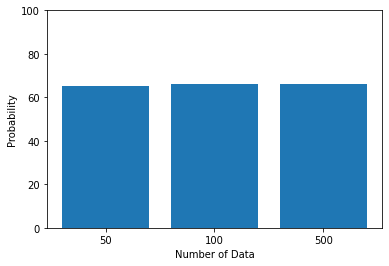

In [12]:
import matplotlib.pyplot as plt

x = np.arange(3)
testCase_num = ['50', '100', '500']
values = [(acc_50 / len(case_50)) * 100, (acc_100 / len(case_100)) * 100, (acc_500 / len(case_500)) * 100 ]

plt.bar(x, values)
plt.xticks(x, testCase_num)
plt.ylim([0, 100])
plt.xlabel('Number of Data')
plt.ylabel('Probability')

plt.show()

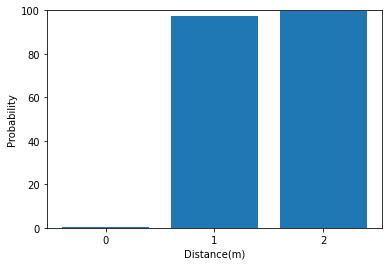

In [13]:
x = np.arange(3)
testCase_num = ['0', '1', '2']
values = [(acc_0 / len(case_0)) * 100, (acc_1 / len(case_1)) * 100, (acc_2 / len(case_2)) * 100 ]

plt.bar(x, values)
plt.xticks(x, testCase_num)
plt.ylim([0, 100])
plt.xlabel('Distance(m)')
plt.ylabel('Probability')

plt.show()

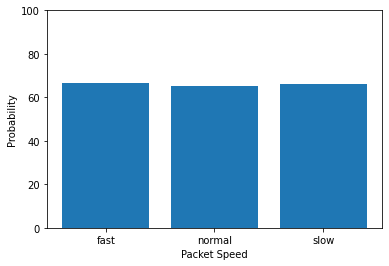

In [14]:
x = np.arange(3)
testCase_num = ['fast', 'normal', 'slow']
values = [(acc_fast / len(case_fast)) * 100, (acc_normal / len(case_normal)) * 100, (acc_slow / len(case_slow)) * 100 ]

plt.bar(x, values)
plt.xticks(x, testCase_num)
plt.ylim([0, 100])
plt.xlabel('Packet Speed')
plt.ylabel('Probability')

plt.show()